In [1]:
# extract rar to temp_folder
!unrar x '/content/drive/MyDrive/Colab Notebooks/assets/data.rar' '/content/temp/'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/Colab Notebooks/assets/data.rar

Creating    /content/temp                                             OK
Creating    /content/temp/skin cancer                                 OK
Creating    /content/temp/skin cancer/SET_D                           OK
Extracting  /content/temp/skin cancer/SET_D/D1.BMP                         0%  OK 
Extracting  /content/temp/skin cancer/SET_D/D10.BMP                        0%  OK 
Extracting  /content/temp/skin cancer/SET_D/D100.BMP                       0%  OK 
Extracting  /content/temp/skin cancer/SET_D/D1000.BMP                      0%  OK 
Extracting  /content/temp/skin cancer/SET_D/D101.BMP                       0%  OK 
Extracting  /content/temp/skin cancer/SET_D/D102.BMP                       0%  OK 
Extracting  /content/temp/skin cancer/SET_D/D103.BMP                       0%  

In [2]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from math import ceil

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

In [3]:
# cross-platform forward slash path notation
assets_folder = Path('/content/drive/MyDrive/Colab Notebooks/assets')
temp_folder = Path('/content/temp')

# list absolute paths to every extracted file
original_rar_file_list = [os.path.join(r, file) for r,d,f in os.walk(temp_folder) for file in f]

# get only the rows/colmns containing data from CLIN_DIA.xlsx
images_diag_df = pd.read_excel(assets_folder / 'CLIN_DIA.xlsx')
images_diag_df.dropna(axis=0, how='all', inplace=True)
images_diag_df.dropna(axis=1, how='all', inplace=True)

# filter out non-existent images and files where diagnose wasn't finshed yet
def construct_image_path(image_diag_row):
  """Return the path for the image in the diag df, if it exists, otherwise, return NaN"""
  try:
    return [path for path in original_rar_file_list if image_diag_row['id'].upper()+'.BMP' in path][0]
  except:
    return np.nan

images_diag_df['filepath'] = images_diag_df.apply(construct_image_path, axis = 1)
images_diag_df.dropna(axis = 0, subset=['filepath'], inplace=True)
images_diag_df = images_diag_df[images_diag_df['kat.Diagnose'].isin([1,2,3])]

# create binary label based on kat.Diagnose
# 1		==> no_doctor
# 2/3	==> doctor
images_diag_df['label'] = images_diag_df['kat.Diagnose'].apply(lambda x: 'no_doctor' if x == 1 else 'doctor')

# split the images_diag_df in train and test with each 22% cases that should see a doctor
images_diag_train, images_diag_test = train_test_split(images_diag_df, test_size=0.1, random_state=101, stratify=images_diag_df['label'])
print('% see doctor cases - train:', images_diag_train[images_diag_train['label'] == 'doctor'].shape[0]/len(images_diag_train))
print('% see doctor cases - test:', images_diag_test[images_diag_test['label'] == 'doctor'].shape[0]/len(images_diag_test))

% see doctor cases - train: 0.2168582375478927
% see doctor cases - test: 0.21724137931034482


In [4]:
def selma_secret_sauce(image, advanced = True, bigger_border = False, replicate_border = False, for_training = True, model_size = (256, 256)):
    
    def crop(image):
        '''this function cuts of the small black borders found on training images,
        so that expanding to squares with pixel replication works'''
        cut_left = 2
        cut_right = 2
        cut_top = 2
        cut_bottom = 2
        top_left = (cut_left, cut_top)
        bottom_right = (image.shape[1]-cut_right, image.shape[0]-cut_bottom)
        image = image[top_left[1]:(bottom_right[1] + 1), top_left[0]:(bottom_right[0] + 1)]
        return image
        
    
    def make_square(image, skip_cropping = False):
        '''make square with blurred border replication'''
        if skip_cropping == False:
            image = crop(image)
        if bigger_border == True:
            # enlarge border size to allow more room for augmentation rotation/shifting
            square_dimension = ceil((image.shape[1]**2 + image.shape[0]**2)**0.5*1.1)
        else:
            square_dimension = max(image.shape[1],image.shape[0])
        top_border = (square_dimension-image.shape[0])//2
        bottom_border = square_dimension-image.shape[0]-top_border
        left_border = (square_dimension-image.shape[1])//2
        right_border = square_dimension-image.shape[1]-left_border
        if replicate_border == True:
            square = cv2.copyMakeBorder(image,
                                        top_border,
                                        bottom_border,
                                        left_border,
                                        right_border,
                                        cv2.BORDER_REPLICATE)
            # blur the border (and the whole image)
            square = cv2.GaussianBlur(square,(19,19),cv2.BORDER_DEFAULT)
            # impose unblurred image on blurred square
            yoff = top_border
            xoff = left_border
            square[yoff:yoff+image.shape[0], xoff:xoff+image.shape[1]] = image
        else:
            # fill the border with grey instead
            square = cv2.copyMakeBorder(image,
                                        top_border,
                                        bottom_border,
                                        left_border,
                                        right_border,
                                        cv2.BORDER_CONSTANT,
                                        value = (125, 125, 125))
        
        return square
    
    # convert BMP to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # make square
    square = make_square(image)
    
    # don't continue processing when advanced is False, and resize to model dimension
    # when predicting
    if advanced == False:
        if for_training == False:
            square = cv2.resize(square, model_size, interpolation = cv2.INTER_AREA)
        return square
    
    # convert image to grayScale
    grayScale = cv2.cvtColor(crop(image), cv2.COLOR_RGB2GRAY)

    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
    
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    
    # inpaint with original image and threshold image
    hair_removal_image = cv2.inpaint(crop(image),threshold,1,cv2.INPAINT_TELEA)
    hair_removal_image = cv2.medianBlur(hair_removal_image,5)
    
    #-----Converting image to LAB Color model-----------------------------------
    lab = cv2.cvtColor(hair_removal_image, cv2.COLOR_RGB2LAB)
    
    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)
    
    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    
    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))
    
    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # make square and resize in case of prediction
    final = make_square(final, skip_cropping = True)
    if for_training == False:
        final = cv2.resize(final, model_size, interpolation = cv2.INTER_AREA)
    return final

    #_____END_____#

In [5]:
# create directory structure
structure = [ 'train', 'test', 'train/a_no_doctor', 'train/b_doctor', 'test/a_no_doctor', 'test/b_doctor']
for dir in structure:
  dir = temp_folder / dir
  if not dir.exists():
    os.mkdir(dir)

current_rows = 'train'
progress_counter = 0

for rows in (images_diag_train.iterrows(), images_diag_test.iterrows()):
  for index, row in rows:
    # pre-processing part
    image = cv2.imread(f"{row['filepath']}")
    image = selma_secret_sauce(image, advanced = True)
    # save to image tree
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if current_rows == 'train':
      if row['label'] == 'no_doctor':
        cv2.imwrite(str(temp_folder / 'train' / 'a_no_doctor' / f"{row['id']}.png"), image)
      else:
        cv2.imwrite(str(temp_folder / 'train' / 'b_doctor' / f"{row['id']}.png"), image)
    else:
      if row['label'] == 'no_doctor':
        cv2.imwrite(str(temp_folder / 'test' / 'a_no_doctor' / f"{row['id']}.png"), image)
      else:
        cv2.imwrite(str(temp_folder / 'test' / 'b_doctor' / f"{row['id']}.png"), image)
    progress_counter += 1
    if progress_counter % 200 == 0:
      print(f'{progress_counter/images_diag_df.shape[0]:.1%}')
  current_rows = 'test'

6.9%
13.8%
20.7%
27.6%
34.5%
41.4%
48.3%
55.2%
62.1%
69.0%
75.9%
82.8%
89.7%
96.6%


In [6]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rotation_range=90,
                                   rescale=1/255,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   cval=125)
                                   
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        temp_folder / 'train',  # This is the source directory for training images
        target_size=(64, 64),  # All images will be resized to 256 x 256
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        temp_folder / 'test',
        target_size=(64, 64),
        batch_size=20,
        class_mode='binary')

Found 2610 images belonging to 2 classes.
Found 290 images belonging to 2 classes.


In [7]:
model = Sequential()

# adding the input layer to vgg model
vgg = VGG16(weights='imagenet',include_top=False, input_shape=(64,64,3))
model.add(vgg)

model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

# don't train the vgg layers:
for layers in model.layers[0].layers:
    layers.trainable = False
    
# And Freeze also layer zero for good measure
model.layers[0].trainable = False

# compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


58892288/58889256 [==============================] - 0s 0us/step


In [8]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=3,
                   restore_best_weights=True)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/best_64mole_model_vgg_advanced_preprocess.h5',
                     monitor='val_accuracy',
                     mode='max',
                     save_best_only=True)

history = model.fit(train_generator,
                           epochs=1000,
                           validation_data=validation_generator,
                           batch_size = 20,
                           callbacks = [es, mc])

model.save_weights("/content/drive/MyDrive/Colab Notebooks/best_64mole_model_vgg_advanced_preprocess_weights.h5")

Epoch 1/1000
131/131 [==============================] - 33s 193ms/step - loss: 0.6422 - accuracy: 0.6784 - val_loss: 0.4797 - val_accuracy: 0.7931
Epoch 2/1000
131/131 [==============================] - 25s 191ms/step - loss: 0.4775 - accuracy: 0.7867 - val_loss: 0.4663 - val_accuracy: 0.8069
Epoch 3/1000
131/131 [==============================] - 25s 190ms/step - loss: 0.4518 - accuracy: 0.8097 - val_loss: 0.4595 - val_accuracy: 0.8103
Epoch 4/1000
131/131 [==============================] - 25s 189ms/step - loss: 0.4695 - accuracy: 0.7831 - val_loss: 0.4585 - val_accuracy: 0.8172
Epoch 5/1000
131/131 [==============================] - 25s 193ms/step - loss: 0.4555 - accuracy: 0.7935 - val_loss: 0.4506 - val_accuracy: 0.8172
Epoch 6/1000
131/131 [==============================] - 25s 191ms/step - loss: 0.4470 - accuracy: 0.7974 - val_loss: 0.4497 - val_accuracy: 0.8172
Epoch 7/1000
131/131 [==============================] - 25s 191ms/step - loss: 0.4428 - accuracy: 0.7977 - val_loss: 0

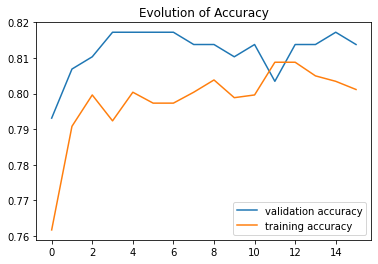

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['accuracy'], label='training accuracy')
plt.title('Evolution of Accuracy')
plt.legend()
plt.show()


In [10]:
# put test set in a numpy array

validation_generator = val_datagen.flow_from_directory(
        temp_folder / 'test',
        target_size=(64, 64),
        batch_size=1,
        class_mode='binary')

y_test = np.empty((0,))
X_test = np.empty((0,64,64,3))
count = 0
for image, label in validation_generator:
  if count > 289:
    break
  y_test = np.append(y_test, label)
  X_test = np.append(X_test, image, axis = 0)
  count += 1

(next(validation_generator))[0].shape
display(y_test.shape)
display(X_test.shape)

Found 290 images belonging to 2 classes.


(290,)

(290, 64, 64, 3)

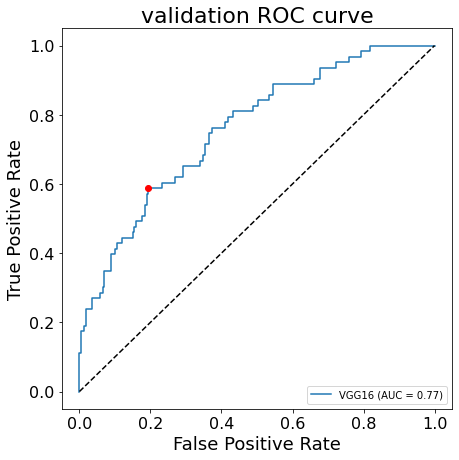

ROC AUC score: 0.76


In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
fig, ax = plt.subplots(figsize = (7,7))
RocCurveDisplay(roc_auc = 0.77, estimator_name = 'VGG16', fpr=fpr, tpr=tpr).plot(ax = ax)
plt.plot(fpr, fpr, '--', c = 'k')
# mark the threshold with the largest difference between tpr and fpr (Youden index)
plt.plot(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], 'ro')

plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('validation ROC curve', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.show()

print('ROC AUC score: {:.2f}'.format(roc_auc_score(y_test, model.predict(X_test))))

In [13]:
def accuracy_scores_display(prediction_probabilities, y_true):
    '''A function calculating and plotting the accuracy scores per decision threshold,
    This score is comparable between datasets of equal class balance.'''
    _, _, thresholds = roc_curve(y_true, prediction_probabilities)
    
    
    #accuracy = true_positive_count + true_negative_count /
    #           total_case_nr
    
    accuracies = np.empty((0,))
    
    for threshold in thresholds[1:]:
        val_positive_indices = np.where(y_true == 1)[0]
        pred_positive_indices = np.where(prediction_probabilities >= threshold)[0]
        true_positive_count = np.intersect1d(val_positive_indices, pred_positive_indices).shape[0]
        val_negative_indices = np.where(y_true == 0)[0]
        pred_negative_indices = np.where(prediction_probabilities < threshold)[0]
        true_negative_count = np.intersect1d(val_negative_indices, pred_negative_indices).shape[0]
        
        accuracy = (true_positive_count + true_negative_count) / y_true.shape[0]
        
        accuracies = np.append(accuracies, accuracy)
        
    plt.plot(thresholds[1:], accuracies, label = f'Accuracy')
    plt.plot(thresholds[1:][np.argmax(accuracies)],accuracies.max(), 'ro')
    plt.title('Prediction threshold tuning')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axvline(x=thresholds[1:][np.argmax(accuracies)], c = 'r')
    plt.gca().annotate(f'max accuracy: {accuracies.max():.2f}',
                       xy=(thresholds[1:][np.argmax(accuracies)]+0.01, 0.96),
                       horizontalalignment='left',
                       xycoords='data')
    plt.gca().annotate(f'threshold: {thresholds[1:][np.argmax(accuracies)]:.3f}',
                       xy=(thresholds[1:][np.argmax(accuracies)]+0.01, 0.91),
                       horizontalalignment='left',
                       xycoords='data')
    plt.legend(loc = 'upper left')
    return plt.gca(), thresholds[1:][np.argmax(accuracies)]

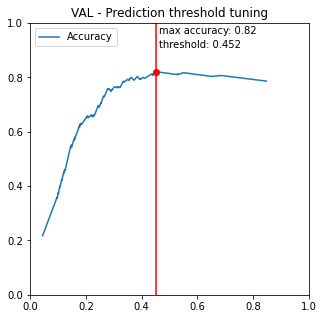

In [14]:
plt.figure(figsize = (5,5))
ax, cut_point_accuracy = accuracy_scores_display(model.predict(X_test), y_test)
plt.title('VAL - Prediction threshold tuning')
plt.show()

In [15]:
from sklearn.metrics import f1_score

print(f1_score(y_test, model.predict(X_test).round(0)))


0.32499999999999996


In [16]:
def f_beta_scores_display(prediction_probabilities, y_true, beta):
    '''A function calculating and plotting the F_beta scores per decision threshold,
    where you care beta times more about recall (sensitivity) than precision.
    This score is more informative because it is less sensitive to class imbalance
    compared to accuracy.'''
    _, _, thresholds = roc_curve(y_true, prediction_probabilities)
    
    precisions = np.empty((0,))
    recalls = np.empty((0,))
    f_beta_scores = np.empty((0,))
    
    for threshold in thresholds[1:]:
        val_positive_indices = np.where(y_true == 1)[0]
        pred_positive_indices = np.where(prediction_probabilities >= threshold)[0]
        true_positive_count = np.intersect1d(val_positive_indices, pred_positive_indices).shape[0]
        pred_positive_count = pred_positive_indices.shape[0]
        val_positive_count = val_positive_indices.shape[0]
    
        precision = true_positive_count / pred_positive_count
        recall = true_positive_count / val_positive_count
    
        precisions = np.append(precisions, precision)
        recalls = np.append(recalls, recall)
        
        def f_beta_score(beta, precision, recall):
            return (1 + beta ** 2) * precision * recall / ((beta ** 2 * precision) + recall)
        
        f_beta_scores = np.append(f_beta_scores, f_beta_score(beta, precision, recall))
        
    plt.plot(thresholds[1:], f_beta_scores, label = f'F{beta} score')
    plt.plot(thresholds[1:][np.argmax(f_beta_scores)],f_beta_scores.max(), 'ro')
    plt.title('Prediction threshold tuning')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axvline(x=thresholds[1:][np.argmax(f_beta_scores)], c = 'r')
    plt.gca().annotate(f'max F{beta} score: {f_beta_scores.max():.2f}',
                       xy=(thresholds[1:][np.argmax(f_beta_scores)]-0.01, 0.09),
                       horizontalalignment='right',
                       xycoords='data')
    plt.gca().annotate(f'threshold: {thresholds[1:][np.argmax(f_beta_scores)]:.3f}',
                       xy=(thresholds[1:][np.argmax(f_beta_scores)]-0.01, 0.04),
                       horizontalalignment='right',
                       xycoords='data')
    plt.legend(loc = 'upper left')
    return plt.gca(), thresholds[1:][np.argmax(f_beta_scores)]

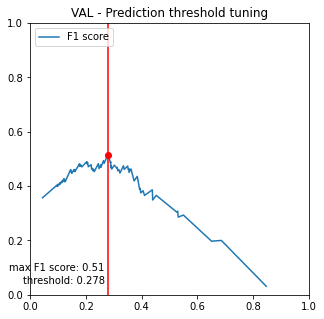

In [17]:
plt.figure(figsize = (5,5))
ax, cut_point_F1 = f_beta_scores_display(model.predict(X_test), y_test, 1)
#f_beta_scores_display(1 - model.predict(X_train).ravel(), 1 - y_train, 1)
#accuracy_scores_display(model.predict(X_test).ravel(), y_test)
plt.title('VAL - Prediction threshold tuning')
plt.show()

[Text(0, 0.5, 'no_doctor'), Text(0, 1.5, 'doctor')]

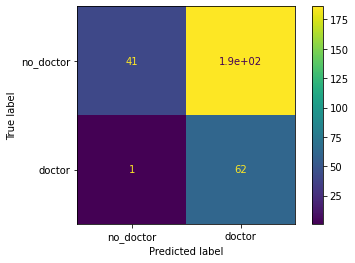

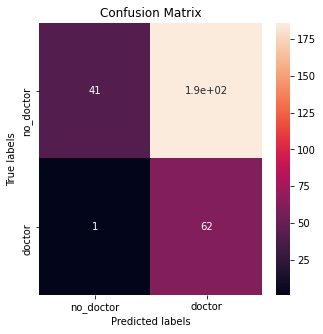

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

labels = ['no_doctor', 'doctor'] # 0, 1

cm = confusion_matrix(y_test, (model.predict(X_test) >= 0.096807286).astype("int32").ravel())
disp = ConfusionMatrixDisplay(cm, display_labels = labels)
disp.plot()

plt.figure(figsize = (5,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([labels[0], labels[1]])
ax.yaxis.set_ticklabels([labels[0], labels[1]])




In [67]:
fpr[-3], tpr[-3], thresholds[-3]

(0.8193832599118943, 0.9841269841269841, 0.096807286)